In [27]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
import src
from pathlib import Path

data_dir = Path(src.__file__).parent.parent / "data"


In [28]:
biasi_analysis = pd.read_csv(data_dir / "biasi.csv")
biasi_analysis

,Fault Branch,Site Code,Site*,Number of Earthquakes,Open Interval,LN: Exp(⁠⁠) (Yr),LN,EXP: (Yr),LN CP of Event in 100 Yr after 1918†,EXP CP of Event in 100 Yr after 1918†,C1 Base Rate Fraction,C2 Base Rate Fraction,C1m Rate Fraction,C2m Rate Fraction
0,SmSAF,COA,Coachella,7,300,132,0.78,181,0.50,0.41,1,0,1.00,0.30
1,NaN,TP,Thousand Palms,5,300,231,0.50,298,0.49,0.27,0,1,0.20,1.00
2,SSAF,BUR,Burro Flats,9,206,175,0.79,237,0.42,0.33,0,1,0.75,1.00
3,NaN,PIT,Pitman Canyon,7,206,140,0.65,181,0.57,0.41,0,0,0.80,0.50
4,SJF,HOG,Hog Lake,21,100,150,0.74,191,0.29,0.39,1,0,1.00,0.50
5,NaN,MYS,Mystic Lake,11,191,135,0.71,172,0.54,0.42,0,1,0.50,1.00
6,SSAF,WW,Wrightwood,15,161,86,0.65,107,0.74,0.59,0,0,0.20,0.35
7,NaN,PAL,Pallett Creek,10,161,121,0.65,152,0.60,0.46,0,1,0.50,1.00
8,NaN,FRA,Frazier Mountain,10,161,87,0.86,119,0.64,0.55,1,0,1.00,0.50
9,NaN,BID,Bidart Ranch,6,161,90,0.71,120,0.69,0.55,0,0,0.20,0.25


In [29]:
t1 = biasi_analysis["Open Interval"] - 100
t2 = t1 + 100
lam = 1/biasi_analysis['EXP:\xa0\xa0(Yr)'] # lambda for the exponential model

# the conditional event probability is: 
# the probability that the event is in the event interval conditional on there being quiescance up to 1918
# F(t2) - F(t1) / (1 - F(t1)) 
CP = (np.exp(-lam * t1) - np.exp(-lam * t2)) / (np.exp(-lam*t1)) 

In [30]:
np.prod(1-CP * biasi_analysis["C1 Base Rate Fraction"])

np.float64(0.04226778250988647)

Poisson processes are memomyless so the conditioning is not necessary

In [31]:
tau = 100
np.prod(((np.exp(-lam*tau)).values)[np.bool(biasi_analysis["C1 Base Rate Fraction"].values)])

np.float64(0.04226778250988648)

### Log normal


In [32]:
import scipy.special


mu = np.log(biasi_analysis["LN: Exp(\u2060\u2060) (Yr)"]).values
sigma = biasi_analysis["LN"].values

t = np.atleast_2d(np.linspace(0,100000, 100000)).T
dt = t[1]-t[0]

waiting_time_pdf = (
    1 -  0.5 * (1 + scipy.special.erf((np.log(t) - mu) / (sigma * np.sqrt(2))))
)/np.exp(mu + sigma**2/2)   

CP = 1 - (waiting_time_pdf[np.squeeze(t) > tau, :] * dt).sum(axis=0)
np.prod(1-CP * biasi_analysis["C1 Base Rate Fraction"])


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_69662/26180430.py:11: RuntimeWarning: divide by zero encountered in log
  1 -  0.5 * (1 + scipy.special.erf((np.log(t) - mu) / (sigma * np.sqrt(2))))


np.float64(0.02778455952807628)

## lognormal analytical

$$ f_W(t) = \frac{S(t)}{\langle T \rangle} $$

where

$$ f(t) = \text{Lognormal}(\mu, \sigma^2) $$

and 

$$ S(t) = 1 - \Phi((\ln(t)-\mu)/\sigma) $$

So, 

$$ S_W(t) = \int_t^{\infty} f_W(t) dt = \frac{1}{\langle T \rangle} \int_t^{\infty} 1 - \Phi((\ln(t)-\mu)/\sigma) dt$$ 

Which involves the integral of the error function.

According to GPT5 with 2 min and 50s or thining time (promted with "can you very rigorously double check your logic, code and math?")

$$ \int_t^{\infty} 1 - \Phi((\ln(t)-\mu)/\sigma) dt = e^{\mu+\sigma^2/2}\left(1-\Phi(z-\sigma)\right)- t(1 - \Phi(z))$$

where 

$$ z=(\ln(t) - \mu)/\sigma $$

Below I check this answer numerically:

In [33]:
z = (np.log(t[1:]) - mu)/sigma

T_mean = np.exp(mu + 0.5*sigma**2)

Sw = scipy.stats.norm.sf(z-sigma) - t[1:]/T_mean*scipy.stats.norm.sf(z)

In [34]:
from scipy.stats import norm  # standard normal
def waiting_survival_lognormal(t, mu, sigma):
    t = np.asarray(t, dtype=float)
    if np.any(t <= 0):
        raise ValueError("t must be > 0 for lognormal.")
    mean_T = np.exp(mu + 0.5 * sigma**2)
    z = (np.log(t) - mu) / sigma
    Sw = norm.sf(z - sigma) - (t / mean_T) * norm.sf(z)
    # numerical guard: clamp tiny negatives to 0
    return np.clip(Sw, 0.0, 1.0)

Sw = waiting_survival_lognormal(t[1:], mu, sigma)

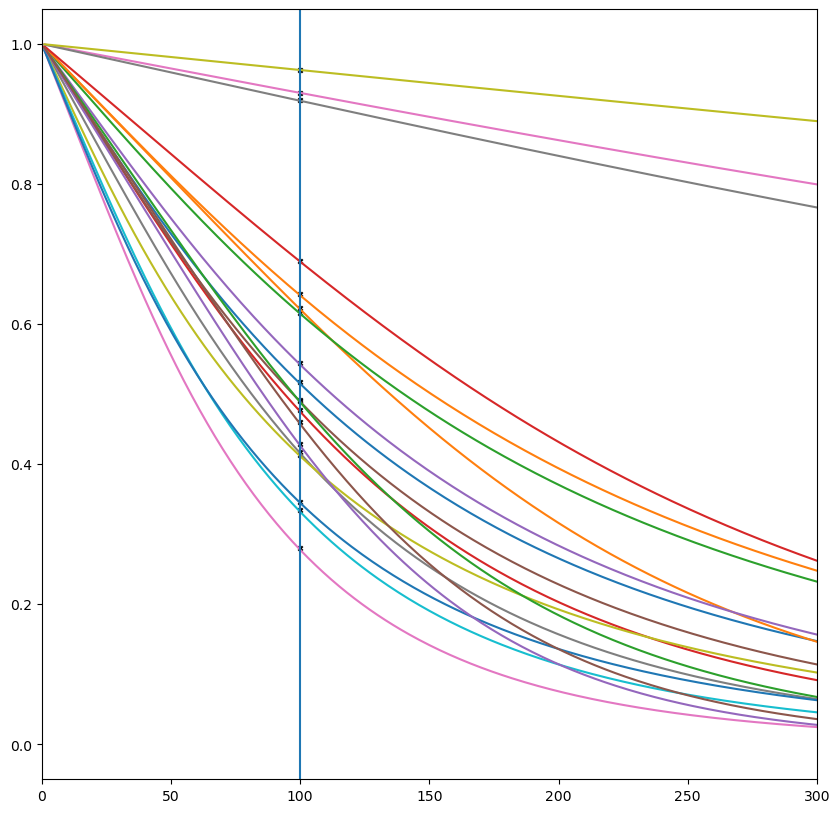

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(t[1:], Sw)
ax.set(xlim=(0,300))
ax.axvline(tau)
ax.scatter(tau*np.ones_like(mu), (waiting_time_pdf[np.squeeze(t) > tau, :] * dt).sum(axis=0), s=10, c='k', marker='x')


I take all crosses corresponding to an intersection of the survival curves with 100 year mark as indication that the numerical calculation calculaiton matches the analytical calculaiton

In [36]:
mask = biasi_analysis["C1 Base Rate Fraction"].astype(bool)
np.prod(waiting_survival_lognormal(100, mu, sigma)[mask])

np.float64(0.027282653057870736)

In [37]:
lam.shape

(19,)

## Weibull Analytical

In [38]:
k = 1 # k=1 is the special case of the exponential function
lam = np.atleast_2d(biasi_analysis['EXP:\xa0\xa0(Yr)']) # confusingly the inverse of the exponential
Sw = (scipy.special.gammaincc(1/k, (t/lam)**k))

Text(0.5, 1.0, 'Log-normal')

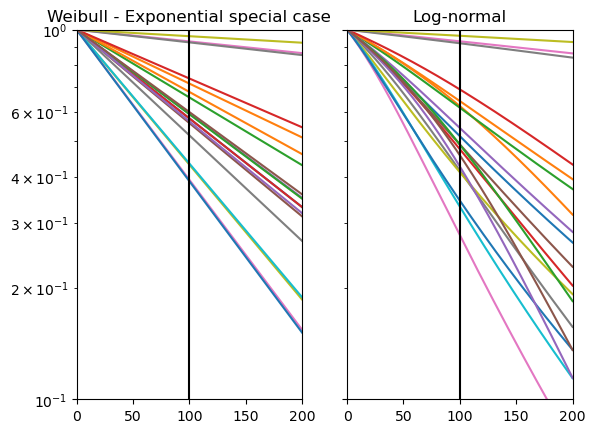

In [39]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].plot(t,Sw)
ax[1].plot(t[1:], waiting_survival_lognormal(t[1:], mu, sigma))
ax[1].set(
    xlim=(0,200),
    ylim=(0.1,1),
    yscale='log',
)
ax[0].axvline(100,c='k')
ax[1].axvline(100,c='k')
ax[0].set_title('Weibull - Exponential special case')
ax[1].set_title('Log-normal')

np.float64(-15.175460663304897)

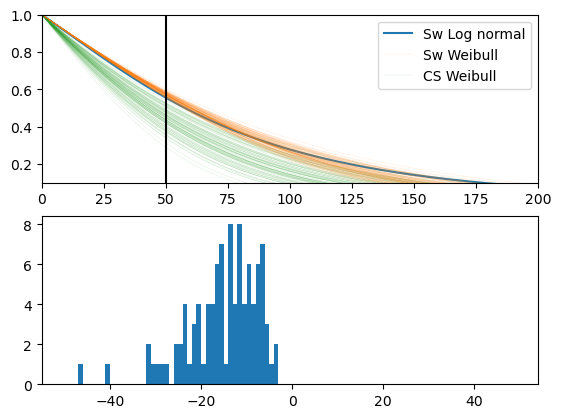

In [40]:

# see paleaoseismicity example with filename = "SAF_Wrightwood.txt"

k = [1.6893499462775003,
 1.9154908372447044,
 1.58979585401506,
 1.993528857716512,
 1.961147387136731,
 2.223306522172223,
 1.7112199749230808,
 1.4358057406528835,
 1.6842422623529005,
 1.7594874636057614,
 1.5253430789101503,
 1.7821902775927183,
 2.002936138525781,
 1.492297402570517,
 1.739724948579447,
 2.271649322466069,
 1.7031674574003663,
 1.819363393425932,
 1.3257905238426635,
 1.5773033343038654,
 1.6839159569559992,
 2.0779083142385693,
 1.925487424692699,
 1.666963022139757,
 1.7972692426816073,
 1.6351807754252832,
 1.5508028408928975,
 1.4653906015752591,
 1.7511171940381831,
 2.2836160487778097,
 1.834716481687573,
 1.686604717036611,
 1.4847335533237183,
 1.455314608262486,
 1.981382875516284,
 1.9351374670567487,
 1.3906012599565702,
 2.0988147295925144,
 1.314811407988858,
 2.138095719691501,
 2.01753452230753,
 1.586213606945819,
 1.8210034474907688,
 2.0981073925520968,
 1.5594076687019682,
 2.57168753420007,
 1.7561363248588493,
 1.9226318065929524,
 1.9577343054298468,
 2.011342183771663,
 1.8357058141063498,
 1.9525029715834898,
 2.045911395297378,
 1.715097730158827,
 1.9157343647271625,
 1.7890105741254483,
 1.9971678544476348,
 1.9943525665480633,
 1.9687413131311873,
 1.6539286382516856,
 2.316586462090966,
 2.0197756639223177,
 1.4596765952243493,
 1.5823926772057575,
 1.8827766755848847,
 1.5230979800977382,
 2.21475127719141,
 1.675388036803314,
 2.670018186733044,
 1.4654383687694506,
 1.8723914222332965,
 1.7273317211794006,
 1.516074231714698,
 1.9679552097491473,
 2.0426175144785894,
 1.6448811590831958,
 1.8515104185570859,
 1.801247218299713,
 1.4347284692592674,
 2.001202575536266,
 1.778668414393482,
 2.3524471953715285,
 2.102024762901923,
 1.560115331324847,
 1.5288865627905475,
 2.1647893025228404,
 2.085771976642379,
 2.2154633248702873,
 1.9229446713806686,
 1.8741305906908252,
 1.744649416204343,
 1.586490741401775,
 1.6943522818817074,
 1.608222869060739,
 1.7905849841109986,
 2.0855326393547635,
 2.0736701212643167,
 1.9174302700585744,
 2.1163482625614423,
 1.9311610288011225]


lam = [124.63461525546855,
 125.08359540261205,
 118.24468527174572,
 125.8962456463965,
 126.37081580135711,
 122.41706097184861,
 120.21863645810642,
 118.50210449122781,
 118.19711216995027,
 123.60259261044128,
 122.913321329703,
 117.67844630929724,
 125.05074988377933,
 118.18413457937132,
 121.4691357069502,
 121.51726714684625,
 121.75489468452531,
 125.15668295482718,
 120.08207833111831,
 123.88048298122425,
 125.24286684869485,
 122.84838003486946,
 123.54068430065911,
 123.35226911137553,
 121.7345719088085,
 122.54277829165596,
 120.4768227960684,
 118.96049719987916,
 125.42576314034932,
 122.08167135042504,
 124.60037482304423,
 122.65153889252856,
 122.14261728058236,
 120.83871502628622,
 122.65437355468329,
 125.65368782095038,
 118.74391665510838,
 120.62008853934803,
 114.6246600847237,
 122.25440009590267,
 125.6012142817334,
 123.74567446492068,
 125.87731606184855,
 122.25159767144086,
 118.11234102956396,
 125.70121103763276,
 125.02058150735986,
 124.6143761415546,
 124.711146087331,
 125.83818429586199,
 126.55237471224933,
 125.15602078636971,
 123.15767646587415,
 124.45818790795003,
 124.79997682917806,
 121.34588547568819,
 119.83242144859844,
 124.75718607546744,
 124.70721846331449,
 120.40119156815767,
 124.519451912347,
 123.14649294464934,
 117.18331772145733,
 127.07497273203464,
 125.10108890180288,
 120.15479079404119,
 122.53231979116597,
 120.53640952791024,
 125.04500240412492,
 119.58504708020126,
 123.70261741589438,
 121.55163488458638,
 121.26306712906552,
 125.77375666985148,
 122.77936289491976,
 121.4370233258847,
 125.5790053781219,
 122.61234231057243,
 117.92043534270192,
 122.0131107428443,
 121.14315911718911,
 126.66980366613501,
 122.50708684489089,
 121.84794921454501,
 114.67759212166415,
 125.65255719967614,
 121.42300132525273,
 125.43829664194853,
 125.19039488582183,
 120.02849458758489,
 119.6682933198284,
 121.93019482591347,
 119.99202561112146,
 121.58048353013449,
 122.7596448853246,
 125.90246485343373,
 123.90277601781348,
 121.75245064938345,
 121.68207647725771,
 125.58176108297599]

fig, AX = plt.subplots(2,1)

DELTA = 50

ax = AX[0]
swlnh, = ax.plot(t[1:], waiting_survival_lognormal(t[1:], mu[6], sigma[6]), label=r'$S_W$ Log-normal (random observer)')

del_SDELTA = []
for i in range(len(k)):
    
    Sw = (scipy.special.gammaincc(1/k[i], (t/lam[i])**k[i]))
    swwh, = ax.plot(t,Sw, c='C1', alpha=0.5, lw=0.1, label=r'$S_W$ Weibull (random observer)')
    S = np.exp(-((biasi_analysis["Open Interval"][6] - DELTA + t)/lam[i])**k[i])/np.exp(-((biasi_analysis["Open Interval"][6] - DELTA)/lam[i])**k[i])
    scwh, = ax.plot(t, S, c='C2', alpha=0.5, lw=0.1, label=r'$S$ Weibull (Conditional probability)')
    
    del_SDELTA.append((S[np.argmax(t>DELTA)] - Sw[np.argmax(t>DELTA)])/S[np.argmax(t>DELTA)] * DELTA)

del_SDELTA = np.array(del_SDELTA)

ax.legend(["Sw Log normal", "Sw Weibull", "CS Weibull"])
    
# ax.scatter(DELTA, 1 - biasi_analysis["EXP CP of Event in DELTA Yr after 1918†"][6], c='r', marker='x', label='EXP (conditional probability)')
# ax.scatter(DELTA, 1 - biasi_analysis["LN CP of Event in DELTA Yr after 1918†"][6], c='b', marker='x', label='LN (conditional probability)')
ax.set(
    xlim=(0,200),
    ylim=(0.1,1),

)
ax.axvline(DELTA,c='k')
# ax.legend()

ax = AX[1]
ax.hist(del_SDELTA, bins=np.arange(-50, 50, 1))
np.mean(del_SDELTA)



In [41]:
def get_lapse_time(tq, t):
    dt = t - tq
    negative_dt = np.abs(dt[dt < 0])
    return np.min(negative_dt) if np.any(negative_dt) else np.nan

def get_waiting_time(tq, t):
    dt = t - tq
    positive_dt = dt[dt > 0]
    return np.min(positive_dt) if np.any(positive_dt) else np.nan

def get_full_interval(tq, t):
    return get_waiting_time(tq, t) + get_lapse_time(tq, t)





I am beginning to think that the appropriate measure is actually the full interval length of the random observer, not the waiting time. We can do this simply by creating a combined synthetic dataset from the models Biasi puts togetehr for his trenches and combining them in a single time series.

#### Exponential

In [42]:
np.sum(1/(biasi_analysis['EXP:\xa0\xa0(Yr)'][biasi_analysis["C1 Base Rate Fraction"]]))

np.float64(0.09412658978827543)

In [43]:
biasi_selection = biasi_analysis["C2 Base Rate Fraction"].astype(bool)
combined_base_rate = np.sum(1/(biasi_analysis['EXP:\xa0\xa0(Yr)'][biasi_selection]))

# simulate the trench data
t = np.cumsum(np.random.exponential(1/combined_base_rate, 10000))


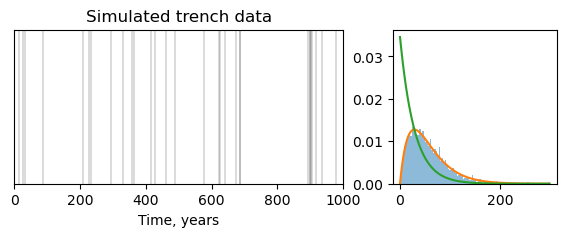

In [44]:
fig, AX = plt.subplots(1, 2, figsize=(7, 2), gridspec_kw={"width_ratios": [2, 1]})

ax = AX[0]
[ax.axvline(t_i, color="k", lw=0.2) for t_i in t];
ax.set(
    xlim=(0,1000),
    title="Simulated trench data",
    xlabel="Time, years",
    yticks=[],
)

ax = AX[1]
tq = np.random.uniform(0, t[-1], 100000)
_, bins, _ = ax.hist([get_full_interval(i_tq, t) for i_tq in tq], bins=100, density=True, alpha=0.5)
ax.plot(bins, bins * combined_base_rate**2 * np.exp(-bins*combined_base_rate), label="Paradox")
ax.plot(bins, combined_base_rate * np.exp(-bins*combined_base_rate), label="Exponential")



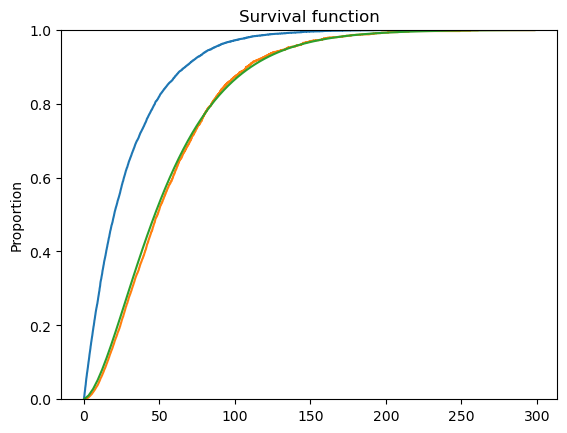

In [45]:
fig, ax = plt.subplots()
ax.set_title('Survival function')
sns.ecdfplot(np.diff(t), ax=ax)
sns.ecdfplot([get_full_interval(i_tq, t) for i_tq in tq], ax=ax)
ax.plot(bins, np.cumsum(np.diff(bins)[0] * bins * combined_base_rate**2 * np.exp(-bins*combined_base_rate)), label="Paradox")

In [46]:
print(
    f"adjusting for length based sampling there is a {((1 - np.cumsum(np.diff(bins)[0] * bins * combined_base_rate**2 * np.exp(-bins*combined_base_rate)))[np.argmax(bins>100)] * 100):.0f}% chance of a 100 year hiatus"
)

print(
    f"Otherwise, per Biasi, there is a {np.exp(-100*combined_base_rate) * 100:.0f}% chance of a 100 year hiatus"
)

adjusting for length based sampling there is a 13% chance of a 100 year hiatus
Otherwise, per Biasi, there is a 3% chance of a 100 year hiatus
